## PSRC Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from seaborn.linearmodels import corrplot,symmatplot

#from sklearn.linear_model import LogisticRegression
#from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import log_loss
#from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

#https://jmetzen.github.io/2015-01-29/ml_advice.html

/Users/xx/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the data sets
data_dir = './data/'
#print (df_Trip_Household_Merged)
#print(df_Trip_Household_Merged.dtypes)

## Pre-processing

In [3]:
df_Trip_Household_Merged = pd.read_csv(data_dir + 'Trip_Household_Merged.csv')


# Filter trips that end outside seattle
df_Trip_Household_Merged = df_Trip_Household_Merged[df_Trip_Household_Merged['uv_dest'] != "Outside Seattle"]

# drop data that are not in urban villages
df_Trip_Household_Merged = df_Trip_Household_Merged[(df_Trip_Household_Merged['uv_origin'] != "Outside Seattle") &
                                                    (df_Trip_Household_Merged['uv_origin'] != "Outside Villages")]

# Create dummie variables for departure time period
depart_period_dummies = pd.get_dummies(df_Trip_Household_Merged['depart_period'])

df_Trip_Household_Merged['weekday_am'] = depart_period_dummies['Weekday AM']
df_Trip_Household_Merged['weekday_mid'] = depart_period_dummies['Weekday Mid']
df_Trip_Household_Merged['weekday_pm'] = depart_period_dummies['Weekday PM']
df_Trip_Household_Merged['weekday_late'] = depart_period_dummies['Late Night']

# Create dummie variables for residency duration, with justs two categories, under and over 5 years (see codebook)
df_Trip_Household_Merged['residency_under5'] = np.where((df_Trip_Household_Merged['res_dur']<=3), 1, 0)
df_Trip_Household_Merged['residency_over5'] = np.where((df_Trip_Household_Merged['res_dur']>3), 1, 0)

# Create dummie variables for home ownership
df_Trip_Household_Merged['hh_rent'] = np.where((df_Trip_Household_Merged['rent_own']==2), 1, 0)
df_Trip_Household_Merged['hh_own'] = np.where((df_Trip_Household_Merged['rent_own']==1), 1, 0)

# Create dummie variables for income
df_Trip_Household_Merged['income_under25'] = np.where((df_Trip_Household_Merged['hhincome_broad']==1), 1, 0)
df_Trip_Household_Merged['income_25_50'] = np.where((df_Trip_Household_Merged['hhincome_broad']==2), 1, 0)
df_Trip_Household_Merged['income_50_75'] = np.where((df_Trip_Household_Merged['hhincome_broad']==3), 1, 0)
df_Trip_Household_Merged['income_75_100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==4), 1, 0)
df_Trip_Household_Merged['income_over100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==5), 1, 0)

##aggregate by geography of origin

geography = ['uv_origin']

trainFeatures = ['google_duration', 'trip_path_distance', 'hhsize', 'hh_rent','hh_own',
            'depart_time','hhincome_broad', 'rent_own', 'numchildren', 'vehicle_count',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late','residency_under5','residency_over5',
                'income_under25', 'income_25_50', 'income_75_100','income_75_100','income_over100','drive_alone']

aggDict = {}
for feature in trainFeatures:
    aggDict[feature]=[sum]

#print (aggDict)

# Apply trip weights prior to aggregation
for feature in trainFeatures:
    df_Trip_Household_Merged[feature] = df_Trip_Household_Merged['trip_wt_final'] * df_Trip_Household_Merged[feature]

aggDict['trip_wt_final'] =[sum]

data = df_Trip_Household_Merged.groupby(geography, as_index=False).agg(aggDict)
data.columns = data.columns.get_level_values(0)


# Reapply column weights to obtain averages for each location
for feature in trainFeatures:
   data[feature] = data[feature] / data['trip_wt_final']

# Create label for geographies under the citywide mean of 30%
data['drive_alone_under30'] = np.where((data['drive_alone'] <= .3), 1, 0)


# drop outlier
#data = data[data['drive_alone'] < .3]
data = data[data['trip_wt_final'] > 1000]

#print(data.columns)
print (data)

/Users/xx/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                           uv_origin  google_duration  trip_path_distance  \
0                        12th Avenue        13.783666            3.084662   
1               23rd & Union-Jackson         9.286290            2.065487   
2                            Admiral        10.715962            2.823961   
3              Aurora-Licton Springs        11.017323            3.361999   
4                            Ballard         8.104783            2.006286   
5          Ballard-Interbay-Northend         9.519243            2.350534   
6                           Belltown         9.690305            1.982422   
7                Bitter Lake Village        13.652500            4.678384   
8                       Capitol Hill        10.259373            1.890594   
9   Chinatown-International District        10.304163            2.373616   
10                     Columbia City        10.013304            2.549925   
11                   Commercial Core         5.124105            1.011690   

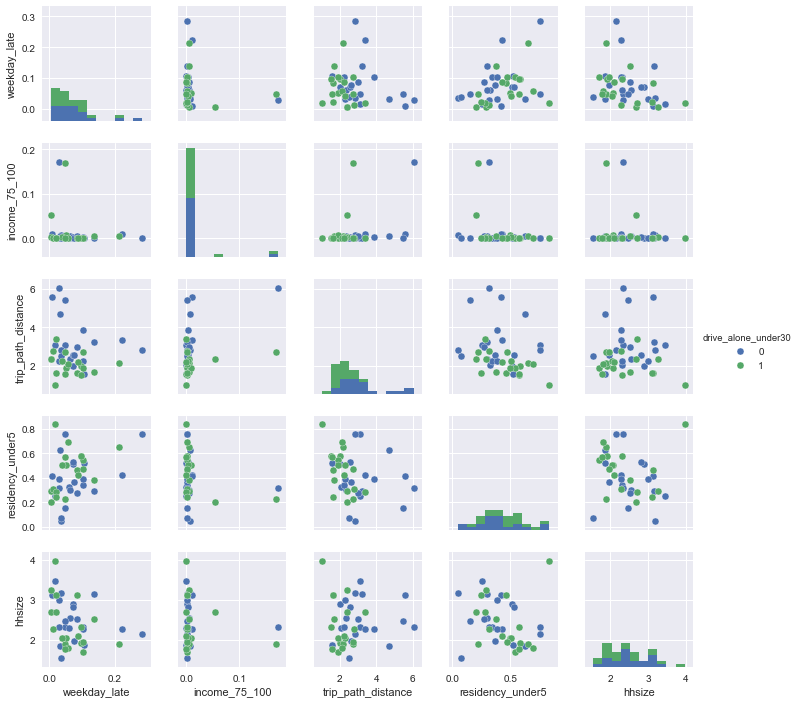

In [4]:
_ = sns.pairplot(data[:50], vars=['weekday_late','income_75_100' , 'trip_path_distance', 'residency_under5', 'hhsize'], hue="drive_alone_under30", size=2)

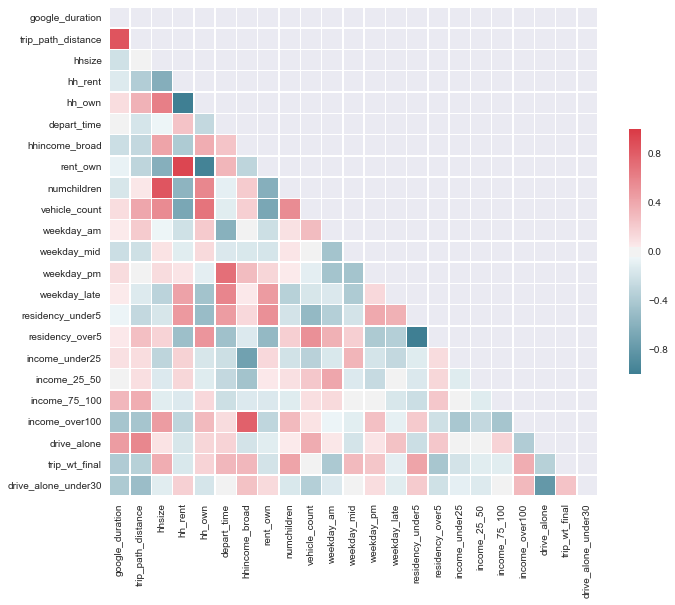

In [5]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Machine Learning Pipeline

Multivariate cross validation with a linear regression model

[-0.75474965] [[-0.01882356  0.13541383  0.16206999 -0.19340639 -0.09622848 -0.02985205
  -0.03065107  0.82953614  0.82260138  0.93570244  2.06235499 -0.0387304
  -0.13267261 -0.82327578 -0.33296803]]
Mean squared error: 0.013
Variance score: 0.634


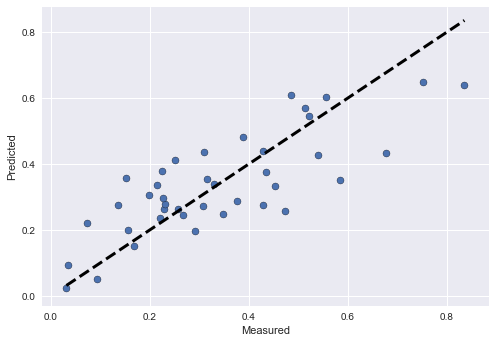

                     0  coefficient
0      google_duration    -0.018824
1   trip_path_distance     0.135414
2               hhsize     0.162070
3     residency_under5    -0.193406
4          numchildren    -0.096228
5        vehicle_count    -0.029852
6               hh_own    -0.030651
7           weekday_am     0.829536
8          weekday_mid     0.822601
9           weekday_pm     0.935702
10        weekday_late     2.062355
11      income_under25    -0.038730
12        income_25_50    -0.132673
13       income_75_100    -0.823276
14      income_over100    -0.332968
mse: 0.0620341430811  variance: -1.10174855564


(0.049964755272424638, -0.84794540150296682)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

features = ['google_duration', 'trip_path_distance', 'hhsize', 'residency_under5',
            'numchildren', 'vehicle_count','hh_own',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late',
            'income_under25', 'income_25_50','income_75_100','income_over100']

feature_list = features

target = ["drive_alone"]

def train_and_cross_val(cols, target):
    
   # Split into features & target.
    features = data[cols]
    target = data[target]

    variance_values = []
    mse_values = []
    
    # kFold instance
    kf = KFold(n=len(data), n_folds=5, shuffle=True, random_state = 3)
    
    # Iterate through each fold
    for train_index, test_index in kf:

        #Training and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Instantiate the model
        model = LinearRegression()
    
        # Fit model to features and target
        model.fit(X_train,y_train)
    
        # Make predictions
        predictions = model.predict(X_test)
    
        # Calulate mse and variance for this fold
        mse = mean_squared_error(y_test, predictions)
        variance = r2_score(y_test, predictions)
    
        # Append to arrays to do calculate overall 
        # average mse and variance values.
        variance_values.append(variance)
        mse_values.append(mse)
        
    # Compute average mse and variance values.
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    
    print ("mse: " + str(mse)," variance: " + str(variance))
        
    return(avg_mse, avg_var)


def train_and_predict(cols, target):

    # Split into features & target.
    features = data[cols]
    target = data[target]

    # Instantiate the model
    model = LinearRegression()
    
    # fit the model
    model.fit(features,target)
    
    # Make predictions
    predictions = model.predict(features)
    mse = mean_squared_error(target, predictions)
    variance = r2_score(target, predictions)
    
    print (model.intercept_, model.coef_)

    # The mean squared error
    print("Mean squared error: %.3f"
      % mean_squared_error(target, predictions))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.3f' % r2_score(target, predictions))

    fig, ax = plt.subplots()
    ax.scatter(target, predictions, edgecolors=(0, 0, 0))
    ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
    df_results = pd.DataFrame(feature_list)
    #df_results['feature'] = features
    df_results['coefficient'] = model.coef_[0]
    print (df_results)
    
train_and_predict(features, target)
train_and_cross_val(features, target)



# Test for Overfitting
At the heart of understanding overfitting is understanding bias and variance. Bias and variance make up the 2 observable sources of error in a model that we can indirectly control. Bias describes error that results in bad assumptions about the learning algorithm. Variance describes error that occurs because of the variability of a model's predicted values. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

For regression, we can use mean absolute error, mean squared error, or R-squared.

We can notice that there is a large gap between error on training and on validation data. What does that mean? We are probably overfitting the training data!
